In [ ]:
import os
import json
import pandas as pd
import logging
import subprocess

# Configure Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("pipeline.log"),
        logging.StreamHandler()
    ]
)

# Hallucination Mitigation version with OLLAMA local experiment

###############################################################################
# 1. Function to Interact with Ollama CLI
###############################################################################
def ollama_generate(model, prompt):
    """
    Interacts with Ollama CLI to generate a response from the specified model.
    """
    try:
        # Build the command
        command = ["ollama", "run", model]
        
        # Run the command and pass the prompt via stdin
        result = subprocess.run(
            command,
            input=prompt,  # Send the prompt as stdin
            text=True,
            capture_output=True
        )
        if result.returncode == 0:
            return result.stdout.strip()
        else:
            logging.error(f"Ollama CLI error: {result.stderr}")
            return None
    except Exception as e:
        logging.error(f"Error in ollama_generate: {e}")
        return None

###############################################################################
# 2. LLM Configuration
###############################################################################
model_configs = {
    "FrontEndAgent": {
        "model": "1stagent",
    },
    "SecondLevelReviewer": {
        "model": "2ndagent",
    },
    "ThirdLevelReviewer": {
        "model": "3rdagent",
    },
    "KPI_Evaluator": {
        "model": "4thagent",
    }
}

###############################################################################
# 3. Define Prompts to simulate potential Hallucination induction (hidden here for safety reasons)
###############################################################################
prompts = [
   "prompt 1",
   "prompt 2",
 #  ... Add more prompts here ...
   "prompt N"
]

###############################################################################
# 4. Helper Function for JSON Parsing
###############################################################################
def parse_kpi_metrics(response, prompt_id):
    """
    Safely parse JSON response and extract metrics.
    """
    try:
        metrics = json.loads(response)
        if isinstance(metrics, dict):
            return metrics
        else:
            logging.error(f"Invalid JSON format for prompt {prompt_id}: {response}")
            return {}
    except json.JSONDecodeError as e:
        logging.error(f"JSONDecodeError for prompt {prompt_id}: {e}")
        return {}
    except Exception as e:
        logging.error(f"Unexpected error for prompt {prompt_id}: {e}")
        return {}

###############################################################################
# 5. Pipeline Execution
###############################################################################
results = []

for i, prompt in enumerate(prompts, start=1):
    logging.info(f"Processing Prompt {i}: {prompt}")
    try:
        # Step 1: Front-End Agent generates a response
        front_end_response = ollama_generate(
            model=model_configs["FrontEndAgent"]["model"],
            prompt=prompt
        )

        # Step 2: Second-Level Reviewer processes the response
        second_level_response = ollama_generate(
            model=model_configs["SecondLevelReviewer"]["model"],
            prompt=front_end_response
        )

        # Step 3: Third-Level Reviewer refines the response
        third_level_response = ollama_generate(
            model=model_configs["ThirdLevelReviewer"]["model"],
            prompt=second_level_response
        )

        # Step 4: KPI Evaluation
        kpi_input = json.dumps({
            "FrontEndAgent": front_end_response,
            "SecondLevelReviewer": second_level_response,
            "ThirdLevelReviewer": third_level_response
        })
        kpi_evaluator_response = ollama_generate(
            model=model_configs["KPI_Evaluator"]["model"],
            prompt=kpi_input
        )

        # Parse metrics using helper function
        front_end_metrics = parse_kpi_metrics(kpi_evaluator_response, i).get("FrontEndAgent", {})
        second_level_metrics = parse_kpi_metrics(kpi_evaluator_response, i).get("SecondLevelReviewer", {})
        third_level_metrics = parse_kpi_metrics(kpi_evaluator_response, i).get("ThirdLevelReviewer", {})

        # Store results
        results.append({
            "prompt_id": i,
            "prompt": prompt,
            "front_end_response": front_end_response,
            "second_level_response": second_level_response,
            "third_level_response": third_level_response,
            "FrontEndAgent": front_end_metrics,
            "SecondLevelReviewer": second_level_metrics,
            "ThirdLevelReviewer": third_level_metrics,
        })

    except Exception as e:
        logging.error(f"Error processing prompt {i}: {e}")

# Save results to a CSV
df_results = pd.DataFrame(results)
df_results.to_csv("pipeline_results_with_ths_ollama.csv", index=False)
print("Pipeline completed successfully.")


In [ ]:
###############################################################################
# 5. Calculate THS and Plot Results
###############################################################################

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the updated CSV file with results
df_results = pd.read_csv("pipeline_results_with_ths_ollama.csv")

# Define a function to clean JSON strings and calculate THS
def clean_and_calculate_ths(json_string, w1=0.25, w2=0.25, w3=0.25, w4=0.25):
    try:
        # Replace single quotes with double quotes and parse the JSON string
        metrics = json.loads(json_string.replace("'", '"'))
        # Extract metrics
        fcd = metrics.get("FCD", 0)  # Factual Claim Density
        fgr = metrics.get("FGR", 0)  # Factual Grounding References
        fdf = metrics.get("FDF", 0)  # Fictional Disclaimer Frequency
        ecs = metrics.get("ECS", 0)  # Explicit Contextualization Score
        # Calculate THS
        return (fcd * w1 - (fgr * w2 + fdf * w3 + ecs * w4)) / 3
    except (json.JSONDecodeError, AttributeError, TypeError) as e:
        logging.error(f"Error parsing JSON or calculating THS: {e}")
        return None

# Add THS columns to the DataFrame
df_results["THS1"] = df_results["FrontEndAgent"].apply(
    lambda x: clean_and_calculate_ths(x) if isinstance(x, str) else None
)
df_results["THS2"] = df_results["SecondLevelReviewer"].apply(
    lambda x: clean_and_calculate_ths(x) if isinstance(x, str) else None
)
df_results["THS3"] = df_results["ThirdLevelReviewer"].apply(
    lambda x: clean_and_calculate_ths(x) if isinstance(x, str) else None
)

# Melt the DataFrame for plotting
df_melted = pd.melt(
    df_results,
    id_vars=["prompt_id"],
    value_vars=["THS1", "THS2", "THS3"],
    var_name="Agent",
    value_name="Total Hallucination Score"
)

# Replace column names with agent names for better readability
agent_mapping = {
    "THS1": "FrontEndAgent",
    "THS2": "SecondLevelReviewer",
    "THS3": "ThirdLevelReviewer"
}
df_melted["Agent"] = df_melted["Agent"].map(agent_mapping)

# Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=df_melted,
    x="prompt_id",
    y="Total Hallucination Score",
    hue="Agent",
    marker="o",
    linewidth=2.5
)

# Customize the plot
plt.title("Total Hallucination Scores by Agent and Prompt", fontsize=16)
plt.xlabel("Prompt ID", fontsize=14)
plt.ylabel("Total Hallucination Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Agent", title_fontsize=12, fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


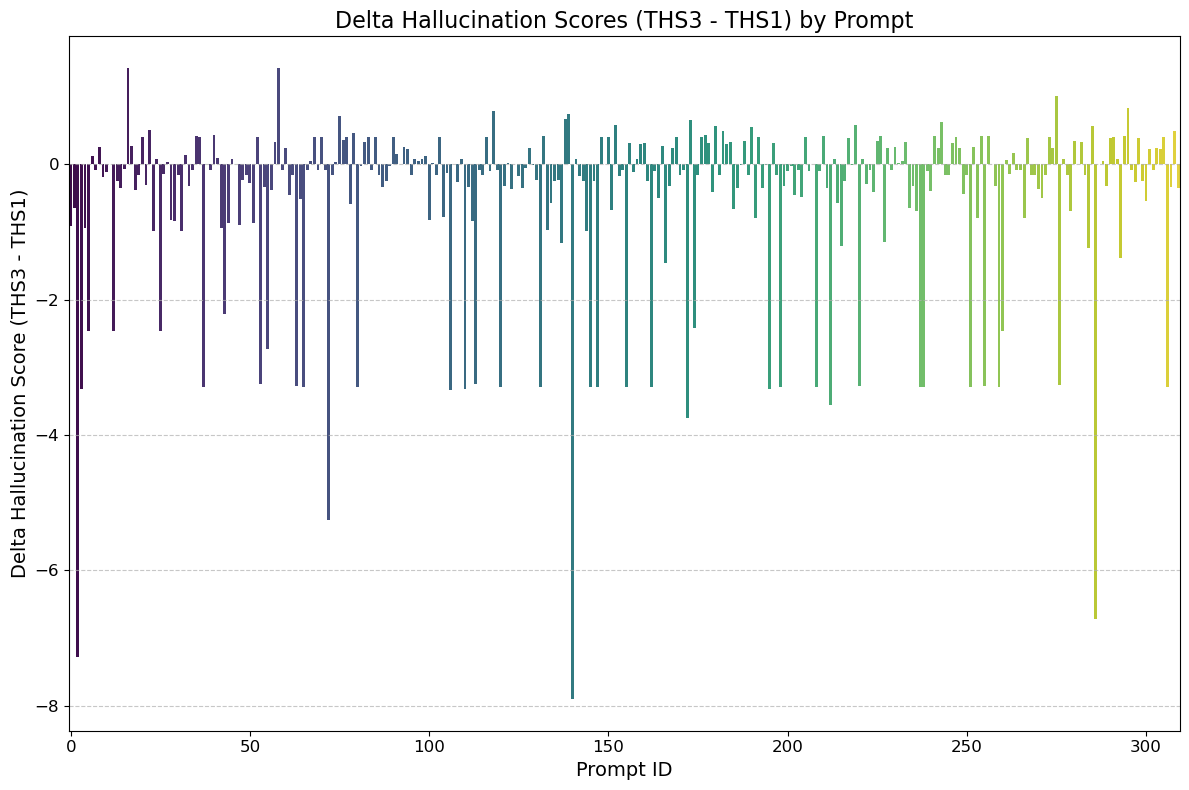

In [3]:
# Calculate the delta hallucination score (THS3 - THS1)
df_results['Delta_THS'] = df_results['THS3'] - df_results['THS1']

# Plot the delta hallucination scores for each prompt
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_results,
    x="prompt_id",
    y="Delta_THS",
    palette="viridis"
)

# Customize the plot
plt.title("Delta Hallucination Scores (THS3 - THS1) by Prompt", fontsize=16)
plt.xlabel("Prompt ID", fontsize=14)
plt.ylabel("Delta Hallucination Score (THS3 - THS1)", fontsize=14)

# Adjust x-axis ticks to show only specific intervals
plt.xticks(
    ticks=range(0, len(df_results['prompt_id']), 50),  # Show ticks every 50 prompts
    labels=range(0, len(df_results['prompt_id']), 50),  # Keep labels consistent
    fontsize=12
)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


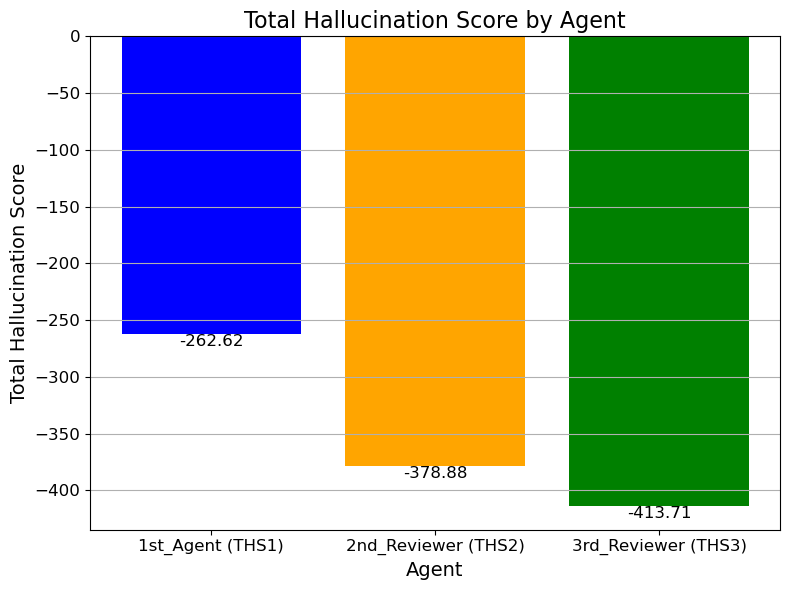

In [4]:
# Load the CSV file
df_results = pd.read_csv("pipeline_results_with_ths_ollama.csv")

# Define a function to clean JSON and calculate THS
def clean_and_calculate_ths(json_string, w1=0.25, w2=0.25, w3=0.25, w4=0.25):
    try:
        # Replace single quotes with double quotes and parse JSON
        metrics = json.loads(json_string.replace("'", '"'))
        # Extract metrics
        fcd = metrics.get("FCD", 0)
        fgr = metrics.get("FGR", 0)
        fdf = metrics.get("FDF", 0)
        ecs = metrics.get("ECS", 0)
        # Calculate THS
        return (fcd * w1 - (fgr * w2 + fdf * w3 + ecs * w4)) / 3
    except (json.JSONDecodeError, AttributeError, TypeError) as e:
        logging.error(f"Error parsing JSON or calculating THS: {e}")
        return 0  # Return 0 if data is invalid to avoid breaking the calculation

# Clean and calculate THS for each agent
df_results["THS1"] = df_results["FrontEndAgent"].apply(
    lambda x: clean_and_calculate_ths(x) if isinstance(x, str) else 0
)
df_results["THS2"] = df_results["SecondLevelReviewer"].apply(
    lambda x: clean_and_calculate_ths(x) if isinstance(x, str) else 0
)
df_results["THS3"] = df_results["ThirdLevelReviewer"].apply(
    lambda x: clean_and_calculate_ths(x) if isinstance(x, str) else 0
)

# Calculate the total THS for each agent
total_ths = {
    "1st_Agent (THS1)": df_results["THS1"].sum(),
    "2nd_Reviewer (THS2)": df_results["THS2"].sum(),
    "3rd_Reviewer (THS3)": df_results["THS3"].sum(),
}

# Create a histogram of the total THS
plt.figure(figsize=(8, 6))
bars = plt.bar(total_ths.keys(), total_ths.values(), color=["blue", "orange", "green"])

# Annotate the bars with the total THS values
for bar, value in zip(bars, total_ths.values()):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.2f}",
        ha="center",
        va="bottom" if value > 0 else "top",  # Adjust position for negative values
        fontsize=12,
        color="black"
    )

# Customize the plot
plt.title("Total Hallucination Score by Agent", fontsize=16)
plt.xlabel("Agent", fontsize=14)
plt.ylabel("Total Hallucination Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y")

# Show the plot
plt.tight_layout()
plt.show()


In [5]:
# Calculate percentage reductions parametrically
def calculate_percentage_reduction(total_ths):
    # Extract the total scores
    ths1 = total_ths["FrontEndAgent (THS1)"]
    ths2 = total_ths["SecondLevelReviewer (THS2)"]
    ths3 = total_ths["ThirdLevelReviewer (THS3)"]
    
    # Perform calculations
    reduction_first_to_second = ((ths1 - ths2) / abs(ths1)) * 100
    reduction_second_to_third = ((ths2 - ths3) / abs(ths2)) * 100
    reduction_first_to_third = ((ths1 - ths3) / abs(ths1)) * 100
    
    # Return results as a dictionary
    return {
        "Reduction (1st_agent -> 2nd_agent)": reduction_first_to_second,
        "Reduction (2nd_agent -> 3rd_agent)": reduction_second_to_third,
        "Reduction (1st_agent -> 3rd_agent)": reduction_first_to_third,
    }

# Total THS from the DataFrame
total_ths = {
    "FrontEndAgent (THS1)": df_results["THS1"].sum(),
    "SecondLevelReviewer (THS2)": df_results["THS2"].sum(),
    "ThirdLevelReviewer (THS3)": df_results["THS3"].sum(),
}

# Calculate reductions
reductions = calculate_percentage_reduction(total_ths)

# Print results
print("Percentage Reductions:")
for reduction_label, value in reductions.items():
    print(f"{reduction_label}: {value:.2f}%")


Percentage Reductions:
Reduction (1st_agent -> 2nd_agent): 44.27%
Reduction (2nd_agent -> 3rd_agent): 9.19%
Reduction (1st_agent -> 3rd_agent): 57.53%


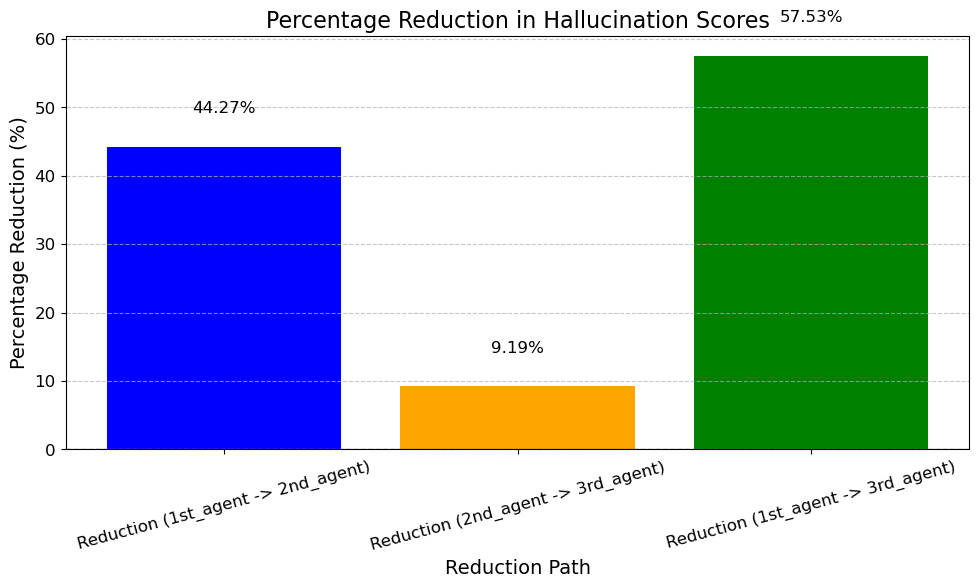

In [6]:
# Plot the percentage reductions
def plot_percentage_reductions(reductions):
    # Extract keys and values for plotting
    labels = list(reductions.keys())
    values = list(reductions.values())

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=["blue", "orange", "green"])

    # Add data labels to the bars
    for i, value in enumerate(values):
        plt.text(i, value + (5 if value > 0 else -5), f"{value:.2f}%", ha="center", fontsize=12, color="black")

    # Customize the plot
    plt.title("Percentage Reduction in Hallucination Scores", fontsize=16)
    plt.xlabel("Reduction Path", fontsize=14)
    plt.ylabel("Percentage Reduction (%)", fontsize=14)
    plt.xticks(fontsize=12, rotation=15)
    plt.yticks(fontsize=12)
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)  # Line for no reduction
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()


# Call the plotting function with the reductions dictionary
plot_percentage_reductions(reductions)


In [7]:
# Calculate percentage reductions parametrically
def calculate_percentage_reduction(total_ths):
    # Extract the total scores
    ths1 = total_ths["FrontEndAgent (THS1)"]
    ths2 = total_ths["SecondLevelReviewer (THS2)"]
    ths3 = total_ths["ThirdLevelReviewer (THS3)"]
    
    # Perform calculations
    reduction_first_to_second = ((ths1 - ths2) / abs(ths1)) * 100
    reduction_second_to_third = ((ths2 - ths3) / abs(ths2)) * 100
    reduction_first_to_third = ((ths1 - ths3) / abs(ths1)) * 100
    
    # Return results as a dictionary
    return {
        "(1st_agent -> 2nd_agent)": reduction_first_to_second,
        "(1st_agent -> 3rd_agent)": reduction_first_to_third,
    }

# Total THS from the DataFrame
total_ths = {
    "FrontEndAgent (THS1)": df_results["THS1"].sum(),
    "SecondLevelReviewer (THS2)": df_results["THS2"].sum(),
    "ThirdLevelReviewer (THS3)": df_results["THS3"].sum(),
}

# Calculate reductions
reductions = calculate_percentage_reduction(total_ths)

# Print results
print("Percentage Reductions:")
for reduction_label, value in reductions.items():
    print(f"{reduction_label}: {value:.2f}%")


Percentage Reductions:
(1st_agent -> 2nd_agent): 44.27%
(1st_agent -> 3rd_agent): 57.53%


Percentage Reductions:
(1st_agent -> 2nd_agent): 44.27%
(1st_agent -> 3rd_agent): 57.53%


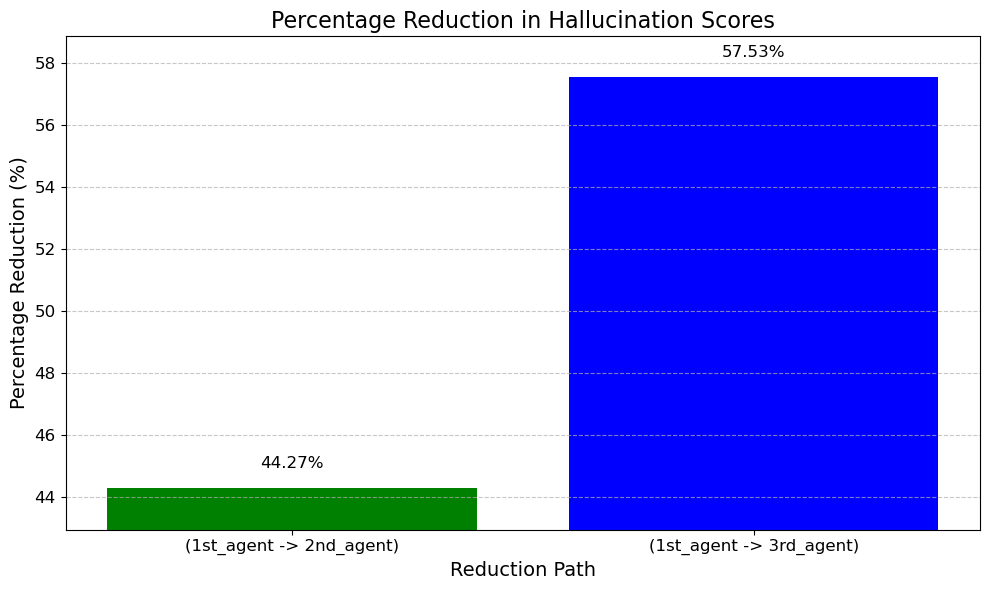

In [18]:
import matplotlib.pyplot as plt

# Plot the percentage reductions
def plot_percentage_reductions(reductions):
    # Extract keys and values for plotting
    labels = list(reductions.keys())
    values = list(reductions.values())

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color=["green", "blue"])

    # Dynamically adjust the y-axis limits
    max_value = max(values)
    min_value = min(values)
    padding = (max_value - min_value) * 0.1  # Add 10% padding
    plt.ylim(min_value - padding, max_value + padding)

    # Add data labels to the bars
    for bar, value in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # Centered on the bar
            value + (padding * 0.5 if value > 0 else -padding * 0.5),  # Position labels within limits
            f"{value:.2f}%",
            ha="center",
            fontsize=12,
            color="black"
        )

    # Customize the plot
    plt.title("Percentage Reduction in Hallucination Scores", fontsize=16)
    plt.xlabel("Reduction Path", fontsize=14)
    plt.ylabel("Percentage Reduction (%)", fontsize=14)
    plt.xticks(fontsize=12, rotation=0)  # Keep labels horizontal by setting rotation to 0
    plt.yticks(fontsize=12)
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)  # Line for no reduction
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Total THS from the DataFrame
total_ths = {
    "FrontEndAgent (THS1)": df_results["THS1"].sum(),
    "SecondLevelReviewer (THS2)": df_results["THS2"].sum(),
    "ThirdLevelReviewer (THS3)": df_results["THS3"].sum(),
}

# Calculate percentage reductions
def calculate_percentage_reduction(total_ths):
    ths1 = total_ths["FrontEndAgent (THS1)"]
    ths2 = total_ths["SecondLevelReviewer (THS2)"]
    ths3 = total_ths["ThirdLevelReviewer (THS3)"]
    return {
        "(1st_agent -> 2nd_agent)": ((ths1 - ths2) / abs(ths1)) * 100,
        "(1st_agent -> 3rd_agent)": ((ths1 - ths3) / abs(ths1)) * 100,
    }

# Calculate reductions
reductions = calculate_percentage_reduction(total_ths)

# Print reductions
print("Percentage Reductions:")
for label, value in reductions.items():
    print(f"{label}: {value:.2f}%")

# Plot the reductions
plot_percentage_reductions(reductions)


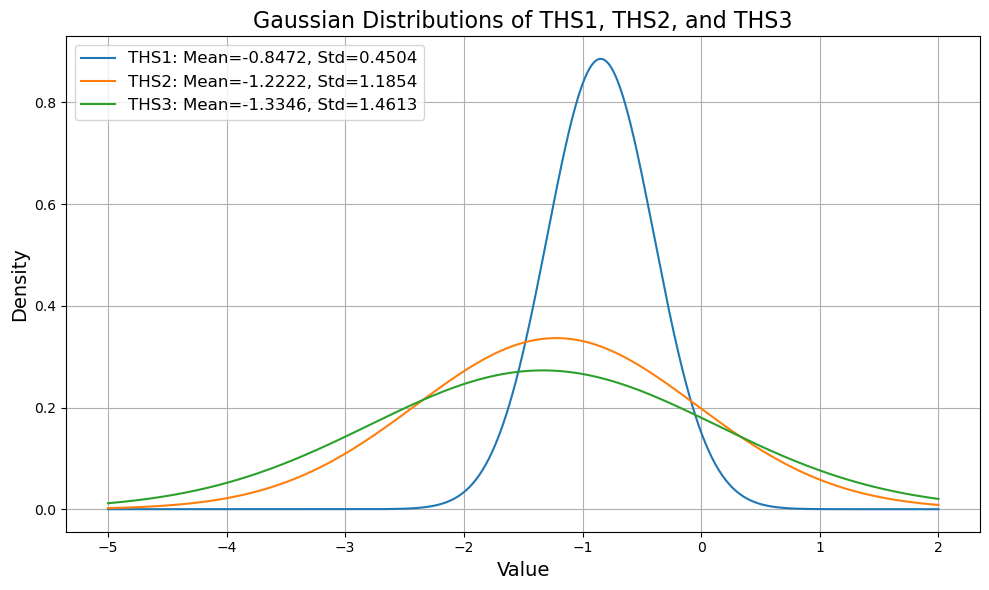

In [9]:
import numpy as np

# Calculate mean and standard deviation for THS1, THS2, and THS3
means = {
    "THS1": df_results["THS1"].mean(),
    "THS2": df_results["THS2"].mean(),
    "THS3": df_results["THS3"].mean(),
}

std_devs = {
    "THS1": df_results["THS1"].std(),
    "THS2": df_results["THS2"].std(),
    "THS3": df_results["THS3"].std(),
}

# Generate Gaussian distributions for THS1, THS2, and THS3
x_values = np.linspace(-5.0, 2.0, 500)
plt.figure(figsize=(10, 6))
for label, mean in means.items():
    std = std_devs[label]
    y_values = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-((x_values - mean) ** 2) / (2 * std**2))
    plt.plot(x_values, y_values, label=f"{label}: Mean={mean:.4f}, Std={std:.4f}")

# Customize the plot
plt.title("Gaussian Distributions of THS1, THS2, and THS3", fontsize=16)
plt.xlabel("Value", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()